In [1]:
from sklearn.preprocessing import MinMaxScaler, FunctionTransformer
from transformer_encoder_decoder_qr_model import TransformerEncoderDecoderQRModel

from utils import *

import random 
import os
import sys 

Using GPU: NVIDIA GeForce RTX 3050 Laptop GPU


In [2]:
nhead =  4      # number of heads in the multi-head attention models
d_model = 32    # model dimension
d_hid = 64      # dimension of the feedforward network model
nlayers = 2     # number of nn.TransformerEncoderLayer in nn.TransformerEncoder
dropout = 0.1   # dropout rate

input_length  = 4  # Number of data points in src
output_length = 1  # Number of data points in tgt
nfeatures  = 1     # Dimension of data - currently only 1d timeseries data
batch_size = 16

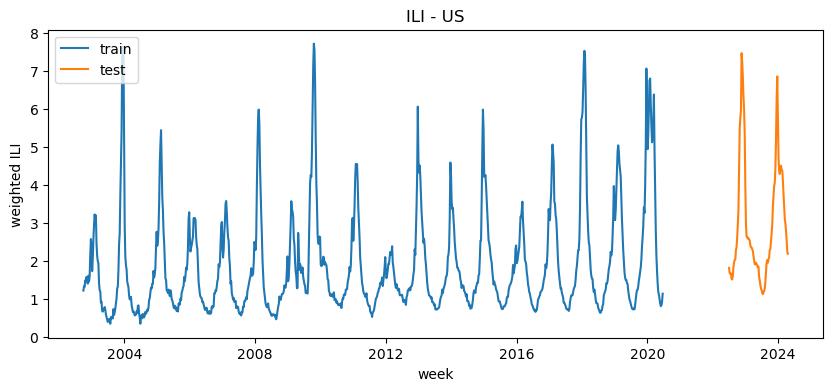

In [3]:
state = 'US'
ILI_df = load_ili_data(state)

# start_covid_date = pd.Timestamp('2020-06-28') 
start_test_date = pd.Timestamp('2022-07-01') 

# train_ind = np.where(ILI_df.index<start_covid_date)[0]
# covid_ind = np.where((ILI_df.index>=start_covid_date) & (ILI_df.index<start_test_date))[0]
train_ind = np.where(ILI_df.index<start_test_date)[0]
test_ind = np.where((ILI_df.index>=start_test_date))[0]

plt.figure(figsize=(10,4))
plt.plot(ILI_df.loc[ILI_df.iloc[train_ind].index,'weighted_ili'],label='train') 
# plt.plot(ILI_df.loc[ILI_df.iloc[covid_ind].index,'weighted_ili'],label='throw (covid)') 
plt.plot(ILI_df.loc[ILI_df.iloc[test_ind].index,'weighted_ili'],label='test') 
plt.ylabel('weighted ILI') 
plt.xlabel('week') 
plt.title('ILI - {}'.format(state)) 
plt.legend(loc=2)
plt.show()

In [4]:
ili = np.expand_dims(ILI_df['weighted_ili'].values,-1)
train_ili = ili[train_ind]
test_ili = ili[test_ind]

test_dates = ILI_df.index[test_ind]

scaler = MinMaxScaler() #FunctionTransformer(lambda x: x) 
scaler.fit(train_ili)
train_data = scaler.transform(train_ili)
test_data = scaler.transform(test_ili)

print(len(train_data))
print(len(test_data))

926
95


In [5]:
def train_and_pred(train_data, test_data, prev_pred_train, prev_pred_test, weeks_ahead):

    training_loader   = get_data_loader(train_data, prev_pred_train, 
                                        input_length, output_length, 
                                        weeks_ahead, batch_size)

    #initializing the model
    model = TransformerEncoderDecoderQRModel(nhead, d_model, d_hid, nlayers, 
                                             input_length, output_length, 
                                             nfeatures, nquantiles, dropout)
    model = model.to(device)

    #training
    min_loss = sys.maxsize 
    training_loss = [] 

    # Training loop
    optimizer = torch.optim.Adam(params = model.parameters(), lr = 1e-3) 
    (model, optimizer, min_loss, training_loss) = \
        run_training_loop(50, optimizer, model, min_loss, training_loss, training_loader)
    optimizer = torch.optim.Adam(params = model.parameters(), lr = 1e-4) 
    (model, optimizer, min_loss, training_loss) = \
        run_training_loop(10, optimizer, model, min_loss, training_loss, training_loader)
    optimizer = torch.optim.Adam(params = model.parameters(), lr = 1e-5) 
    (model, optimizer, min_loss, training_loss) = \
        run_training_loop(10, optimizer, model, min_loss, training_loss, training_loader)

    #training progress
    plot_training_progress = True
    if(plot_training_progress):
        plt.figure()
        plt.title('Training') 
        plt.yscale('log') 
        plt.plot(training_loss, label = 'training') 
        plt.ylabel('Loss') 
        plt.xlabel('Epoch') 
        plt.legend() 
        plt.show()
    
    pred_train = get_model_pred(train_data, prev_pred_train, model, weeks_ahead, input_length, output_length, batch_size)
    pred_test =  get_model_pred(test_data, prev_pred_test, model, weeks_ahead, input_length, output_length, batch_size)
    return (model, pred_train, pred_test)
    

c:\Users\ry2460\anaconda3\envs\timeseries_forecasting\Lib\site-packages\torch\nn\modules\transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
c:\Users\ry2460\anaconda3\envs\timeseries_forecasting\Lib\site-packages\torch\nn\functional.py:5504: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:455.)
  attn_output = scaled_dot_product_attention(q, k, v, attn_mask, dropout_p, is_causal)


epoch 0: train - 1.3412
epoch 1: train - 1.0266
epoch 2: train - 1.016
epoch 3: train - 0.9939
epoch 4: train - 0.7979
epoch 5: train - 0.543
epoch 6: train - 0.4695
epoch 7: train - 0.4369
epoch 8: train - 0.3663
epoch 9: train - 0.363
epoch 10: train - 0.3573
epoch 11: train - 0.327
epoch 12: train - 0.3302
epoch 13: train - 0.3006
epoch 14: train - 0.3126
epoch 15: train - 0.3142
epoch 16: train - 0.3059
epoch 17: train - 0.2882
epoch 18: train - 0.2859
epoch 19: train - 0.2803
epoch 20: train - 0.2748
epoch 21: train - 0.2703
epoch 22: train - 0.2706
epoch 23: train - 0.2765
epoch 24: train - 0.2736
epoch 25: train - 0.2752
epoch 26: train - 0.2719
epoch 27: train - 0.2701
epoch 28: train - 0.2612
epoch 29: train - 0.2645
epoch 30: train - 0.2736
epoch 31: train - 0.2533
epoch 32: train - 0.2641
epoch 33: train - 0.25
epoch 34: train - 0.2491
epoch 35: train - 0.2623
epoch 36: train - 0.2515
epoch 37: train - 0.2664
epoch 38: train - 0.2567
epoch 39: train - 0.2494
epoch 40: train 

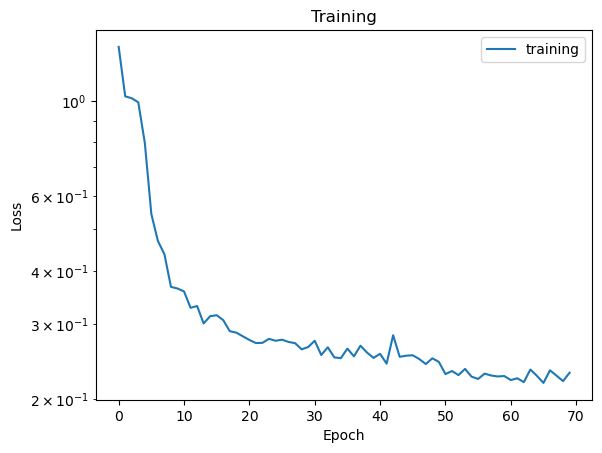

c:\Users\ry2460\anaconda3\envs\timeseries_forecasting\Lib\site-packages\torch\nn\modules\transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


epoch 0: train - 1.2786
epoch 1: train - 1.0593
epoch 2: train - 1.0221
epoch 3: train - 1.0026
epoch 4: train - 0.9815
epoch 5: train - 0.9396
epoch 6: train - 0.6289
epoch 7: train - 0.5416
epoch 8: train - 0.4706
epoch 9: train - 0.4641
epoch 10: train - 0.431
epoch 11: train - 0.4297
epoch 12: train - 0.4225
epoch 13: train - 0.4075
epoch 14: train - 0.4041
epoch 15: train - 0.4095
epoch 16: train - 0.4038
epoch 17: train - 0.3882
epoch 18: train - 0.3887
epoch 19: train - 0.4002
epoch 20: train - 0.3837
epoch 21: train - 0.3849
epoch 22: train - 0.3656
epoch 23: train - 0.3861
epoch 24: train - 0.3814
epoch 25: train - 0.3605
epoch 26: train - 0.3868
epoch 27: train - 0.3683
epoch 28: train - 0.3756
epoch 29: train - 0.3749
epoch 30: train - 0.3569
epoch 31: train - 0.3722
epoch 32: train - 0.3564
epoch 33: train - 0.3804
epoch 34: train - 0.3615
epoch 35: train - 0.3561
epoch 36: train - 0.3656
epoch 37: train - 0.3562
epoch 38: train - 0.3702
epoch 39: train - 0.3679
epoch 40: t

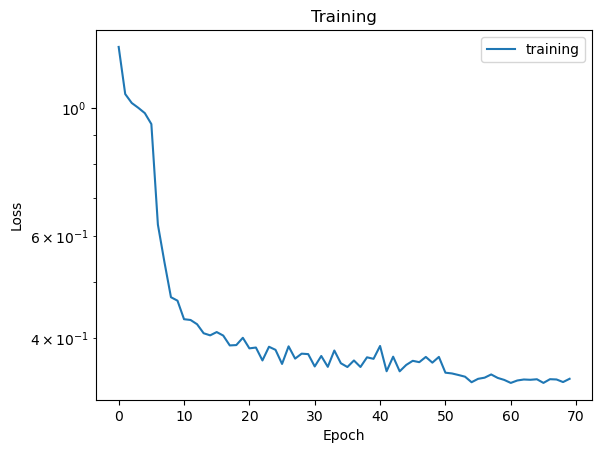

epoch 0: train - 1.3284
epoch 1: train - 1.0551
epoch 2: train - 1.0097
epoch 3: train - 0.9593
epoch 4: train - 0.7212
epoch 5: train - 0.6176
epoch 6: train - 0.5948
epoch 7: train - 0.55
epoch 8: train - 0.5339
epoch 9: train - 0.5256
epoch 10: train - 0.5143
epoch 11: train - 0.4967
epoch 12: train - 0.5102
epoch 13: train - 0.4885
epoch 14: train - 0.4974
epoch 15: train - 0.4932
epoch 16: train - 0.4837
epoch 17: train - 0.4901
epoch 18: train - 0.4802
epoch 19: train - 0.4706
epoch 20: train - 0.4845
epoch 21: train - 0.47
epoch 22: train - 0.4762
epoch 23: train - 0.4794
epoch 24: train - 0.4751
epoch 25: train - 0.4552
epoch 26: train - 0.4571
epoch 27: train - 0.4657
epoch 28: train - 0.4713
epoch 29: train - 0.4675
epoch 30: train - 0.4571
epoch 31: train - 0.4468
epoch 32: train - 0.449
epoch 33: train - 0.4527
epoch 34: train - 0.449
epoch 35: train - 0.4608
epoch 36: train - 0.4182
epoch 37: train - 0.428
epoch 38: train - 0.4381
epoch 39: train - 0.438
epoch 40: train - 

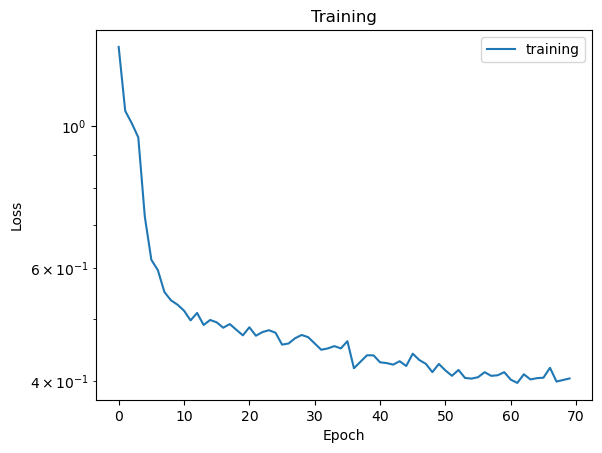

epoch 0: train - 1.3856
epoch 1: train - 1.0618
epoch 2: train - 1.0285
epoch 3: train - 1.0133
epoch 4: train - 0.9774
epoch 5: train - 0.7506
epoch 6: train - 0.67
epoch 7: train - 0.6326
epoch 8: train - 0.5884
epoch 9: train - 0.5707
epoch 10: train - 0.5839
epoch 11: train - 0.5687
epoch 12: train - 0.5405
epoch 13: train - 0.5404
epoch 14: train - 0.5543
epoch 15: train - 0.5324
epoch 16: train - 0.5473
epoch 17: train - 0.5375
epoch 18: train - 0.5254
epoch 19: train - 0.5146
epoch 20: train - 0.5108
epoch 21: train - 0.511
epoch 22: train - 0.5041
epoch 23: train - 0.5101
epoch 24: train - 0.5175
epoch 25: train - 0.5074
epoch 26: train - 0.4965
epoch 27: train - 0.5012
epoch 28: train - 0.5143
epoch 29: train - 0.4969
epoch 30: train - 0.4968
epoch 31: train - 0.5118
epoch 32: train - 0.5071
epoch 33: train - 0.5032
epoch 34: train - 0.4948
epoch 35: train - 0.5174
epoch 36: train - 0.4891
epoch 37: train - 0.5094
epoch 38: train - 0.492
epoch 39: train - 0.5021
epoch 40: trai

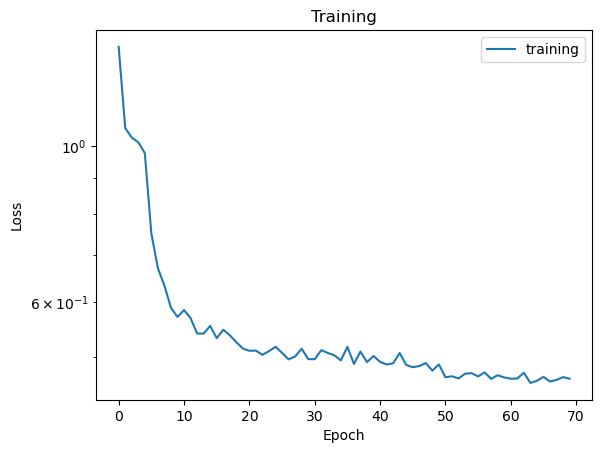

epoch 0: train - 1.2794
epoch 1: train - 1.0433
epoch 2: train - 1.0313
epoch 3: train - 0.9987
epoch 4: train - 0.8688
epoch 5: train - 0.7084
epoch 6: train - 0.6504
epoch 7: train - 0.661
epoch 8: train - 0.6219
epoch 9: train - 0.615
epoch 10: train - 0.5945
epoch 11: train - 0.5934
epoch 12: train - 0.5988
epoch 13: train - 0.5844
epoch 14: train - 0.5747
epoch 15: train - 0.5833
epoch 16: train - 0.5755
epoch 17: train - 0.5891
epoch 18: train - 0.5742
epoch 19: train - 0.5799
epoch 20: train - 0.5622
epoch 21: train - 0.5612
epoch 22: train - 0.56
epoch 23: train - 0.5662
epoch 24: train - 0.5574
epoch 25: train - 0.5523
epoch 26: train - 0.5607
epoch 27: train - 0.5538
epoch 28: train - 0.5642
epoch 29: train - 0.5617
epoch 30: train - 0.5472
epoch 31: train - 0.5572
epoch 32: train - 0.5573
epoch 33: train - 0.5541
epoch 34: train - 0.5437
epoch 35: train - 0.5398
epoch 36: train - 0.5635
epoch 37: train - 0.5429
epoch 38: train - 0.5334
epoch 39: train - 0.5494
epoch 40: trai

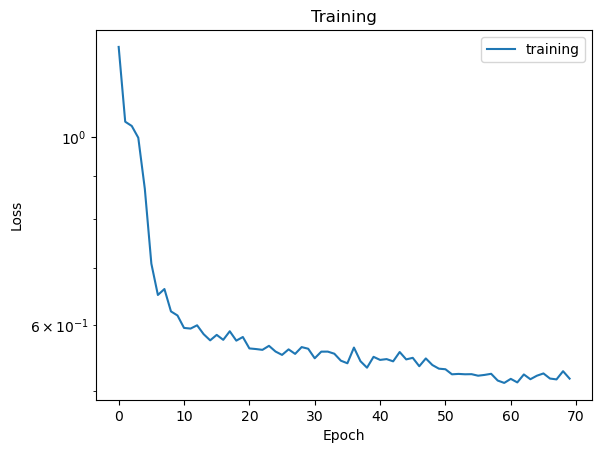

In [6]:
random.seed(1) 
torch.manual_seed(1)

weeks_ahead1 = 1
model1, pred_train1, pred_test1 = train_and_pred(train_data, test_data,
                                                 None, None, weeks_ahead1)

weeks_ahead2 = 2
pred_train_list = [pred_train1]
pred_test_list = [pred_test1]
model2, pred_train2, pred_test2 = train_and_pred(train_data, test_data,
                                                 pred_train_list, pred_test_list, weeks_ahead2)

weeks_ahead3 = 3
pred_train_list = [pred_train1, pred_train2]
pred_test_list = [pred_test1, pred_test2]
model3, pred_train3, pred_test3 = train_and_pred(train_data, test_data,
                                                 pred_train_list, pred_test_list, weeks_ahead3)

weeks_ahead4 = 4
pred_train_list = [pred_train1, pred_train2, pred_train3]
pred_test_list = [pred_test1, pred_test2, pred_test3]
model4, pred_train4, pred_test4 = train_and_pred(train_data, test_data,
                                                 pred_train_list, pred_test_list, weeks_ahead4)

weeks_ahead5 = 5
pred_train_list = [pred_train1, pred_train2, pred_train3, pred_train4]
pred_test_list = [pred_test1, pred_test2, pred_test3, pred_test4]
model5, pred_train5, pred_test5 = train_and_pred(train_data, test_data,
                                                 pred_train_list, pred_test_list, weeks_ahead5)

In [7]:
def get_ili_data_and_pred(pred, ili, dates):
    pred_ili = scaler.inverse_transform(pred)
    #slice ili and test_dates to same dates as pred dates
    ili_slice = ili[(len(ili)-len(pred_ili)):]
    dates_slice = dates[(len(ili)-len(pred_ili)):]
    return (pred_ili,ili_slice,dates_slice)

In [8]:
pred_test_ili1, test_ili1, test_dates1 = get_ili_data_and_pred(pred_test1, test_ili, test_dates, weeks_ahead1)
pred_test_ili2, test_ili2, test_dates2 = get_ili_data_and_pred(pred_test2, test_ili, test_dates, weeks_ahead2)
pred_test_ili3, test_ili3, test_dates3 = get_ili_data_and_pred(pred_test3, test_ili, test_dates, weeks_ahead3)
pred_test_ili4, test_ili4, test_dates4 = get_ili_data_and_pred(pred_test4, test_ili, test_dates, weeks_ahead4)
pred_test_ili5, test_ili5, test_dates5 = get_ili_data_and_pred(pred_test5, test_ili, test_dates, weeks_ahead5)

weeks_ahead=1 (length=91): WIS=0.156, Quantile loss=1.696
weeks_ahead=2 (length=90): WIS=0.294, Quantile loss=3.176
weeks_ahead=3 (length=89): WIS=0.365, Quantile loss=3.924
weeks_ahead=4 (length=88): WIS=0.456, Quantile loss=4.901
weeks_ahead=5 (length=87): WIS=0.527, Quantile loss=5.662


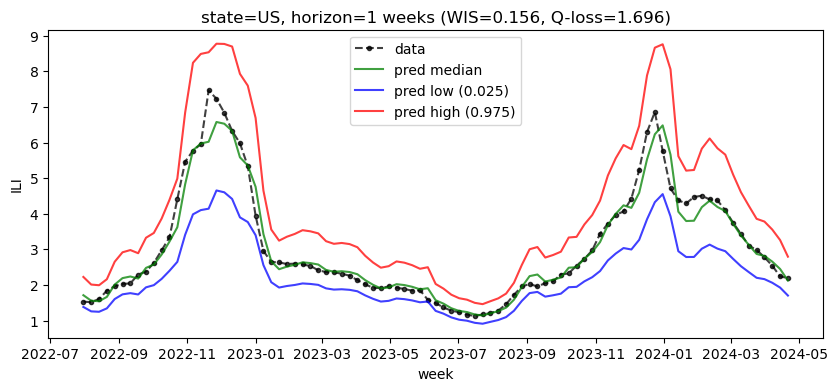

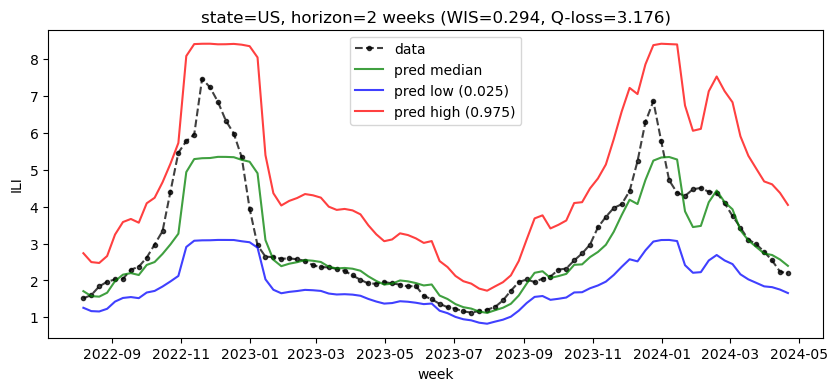

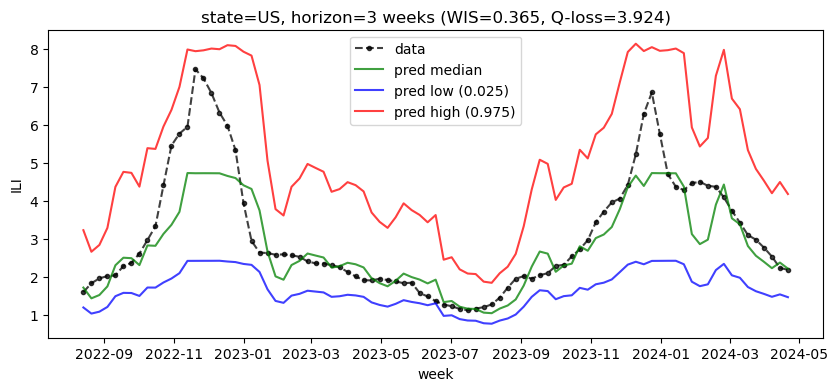

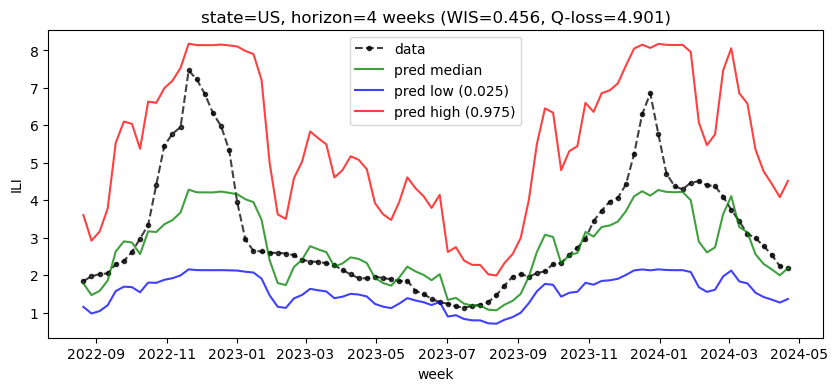

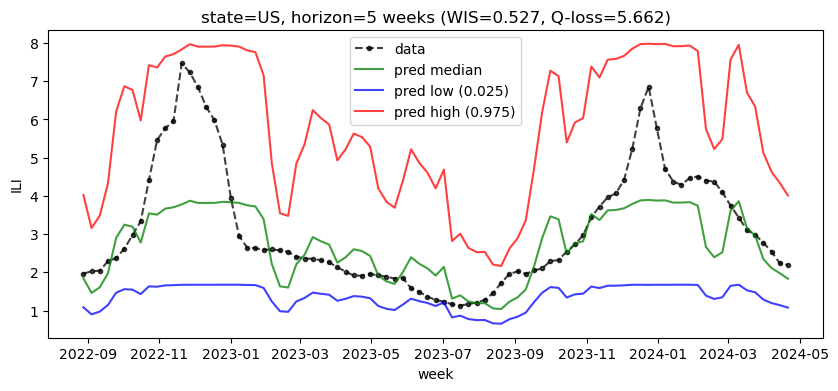

In [9]:
plot_pred_fit(pred_test_ili1, test_ili1, test_dates1, weeks_ahead1, state)
plot_pred_fit(pred_test_ili2, test_ili2, test_dates2, weeks_ahead2, state)
plot_pred_fit(pred_test_ili3, test_ili3, test_dates3, weeks_ahead3, state)
plot_pred_fit(pred_test_ili4, test_ili4, test_dates4, weeks_ahead4, state)
plot_pred_fit(pred_test_ili5, test_ili5, test_dates5, weeks_ahead5, state)

In [10]:
def save_model_and_pred(model, weeks_ahead, test_dates, test_ili, pred_test_ili):
    
    models_folder = './models'
    if not os.path.isdir(models_folder):
        os.makedirs(models_folder)
    model_file = '{}/model_ili_{}_{}w_horizon.pth'.format(models_folder,state,weeks_ahead)
    torch.save({'model_state_dict': model.state_dict()}, model_file)

    df1 = pd.DataFrame(index=test_dates, data=test_ili, columns=['ILI'])
    df2 = pd.DataFrame(index=test_dates, data=pred_test_ili, columns=quantiles)
    df = pd.concat([df1, df2], axis=1)
    output_folder = './output'
    if not os.path.isdir(output_folder):
        os.makedirs(output_folder)
    output_file = '{}/forecasts_ili_{}_{}w_horizon.csv'.format(output_folder,state,weeks_ahead)
    df.to_csv(output_file)


In [11]:
# save_model_and_pred(model1, weeks_ahead1, test_dates1, test_ili1, pred_test_ili1)
# save_model_and_pred(model2, weeks_ahead2, test_dates2, test_ili2, pred_test_ili2)
# save_model_and_pred(model3, weeks_ahead3, test_dates3, test_ili3, pred_test_ili3)
# save_model_and_pred(model4, weeks_ahead4, test_dates4, test_ili4, pred_test_ili4)
# save_model_and_pred(model5, weeks_ahead5, test_dates5, test_ili5, pred_test_ili5)